In [2]:
from google.colab import files
uploaded = files.upload()

Saving admission_predict.csv to admission_predict.csv


# 1b qns 1

iter 0: train error 0.227804
iter 0: test error 0.280764
iter 100: train error 0.019893
iter 100: test error 0.0252215
iter 200: train error 0.0127488
iter 200: test error 0.014113
iter 300: train error 0.00970904
iter 300: test error 0.0106105
iter 400: train error 0.00809519
iter 400: test error 0.00879319
iter 500: train error 0.00711936
iter 500: test error 0.00784907
iter 600: train error 0.0064467
iter 600: test error 0.00721705
iter 700: train error 0.00598576
iter 700: test error 0.00678352
iter 800: train error 0.00564823
iter 800: test error 0.00644928
iter 900: train error 0.0053952
iter 900: test error 0.00619813


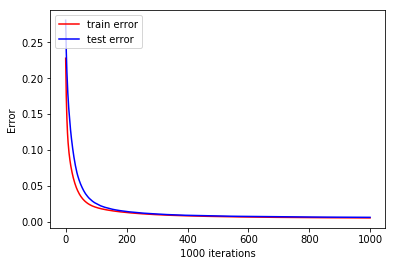

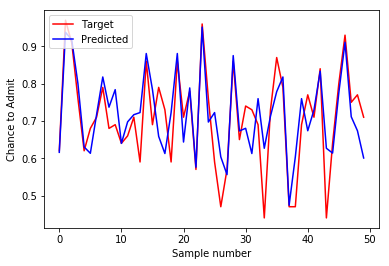

0.0060108304

In [3]:

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import io

seed = 10
tf.set_random_seed(seed)


def get_admission_data(small = None):
  
    np.random.seed(seed) 
    #read and divide data into test and train sets
    admit_data = np.genfromtxt('admission_predict.csv', delimiter= ',')
    X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
    Y_data = Y_data.reshape(Y_data.shape[0], 1)

    idx = np.arange(X_data.shape[0])
    np.random.shuffle(idx)
    X_data, Y_data = X_data[idx], Y_data[idx]

    if small is not None:
        # experiment with small datasets
        X_data = X_data[:small]
        Y_data = Y_data[:small]
    
    X_data = (X_data- np.mean(X_data, axis=0))/ np.std(X_data, axis=0)
    
    split = 0.7
    #create train set
    trainX = X_data[:int(X_data.shape[0]*split)]
    trainY = Y_data[:int(Y_data.shape[0]*split)]

    #create test set
    testX = X_data[:int(X_data.shape[0]*split*-1)]
    testY = Y_data[:int(Y_data.shape[0]*split*-1)]
    
    #randomly choose 50 samples from test set
    rand = np.random.choice(testX.shape[0], 50, replace=True)
    testX = testX[rand]
    testY = testY[rand]
    return trainX, trainY, testX, testY

def gradientDescentOptimizer(trainX, trainY, testX, testY, print_result = False, epochs = 1000, num_layer = 3, num_neuron = 10, with_dropouts = False):
    # initialise constants
    learning_rate = 10**-3
    beta = 10**-3
    batch_size = 8
    NUM_FEATURES = np.size(trainX,1)
    dropout = 0.8
    
    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, 1])
    
    # Build the graph for the deep net
    stddev = 1.0/math.sqrt(NUM_FEATURES)
    
    # hidden layer 1
    seed=10
    weights_h1 = tf.Variable(tf.truncated_normal([NUM_FEATURES,num_neuron], 
                             stddev=stddev, dtype=tf.float32,seed=seed), 
                             name='weights')
    biases_h1 = tf.Variable(tf.zeros([num_neuron]))
    h1 = tf.nn.relu(tf.matmul(x, weights_h1) + biases_h1)
    if with_dropouts:
        h1 = tf.nn.dropout(h1, dropout)

    # hidden layer 2
    seed=20 
    weights_h2 = tf.Variable(tf.truncated_normal([num_neuron,num_neuron], 
                             stddev=stddev, dtype=tf.float32,seed=seed), 
                             name='weights')
    biases_h2 = tf.Variable(tf.zeros([num_neuron]))
    h2 = tf.nn.relu(tf.matmul(h1, weights_h2) + biases_h2)
    if with_dropouts:
        h2 = tf.nn.dropout(h2, dropout)

    # hidden layer 3
    seed=30
    weights_h3 = tf.Variable(tf.truncated_normal([num_neuron,num_neuron], 
                            stddev=stddev, dtype=tf.float32,seed=seed), 
                             name='weights')
    biases_h3 = tf.Variable(tf.zeros([num_neuron]))
    h3 = tf.nn.relu(tf.matmul(h2, weights_h3) + biases_h3)
    if with_dropouts:
        h3 = tf.nn.dropout(h3, dropout)
        
        
    #output layer
    seed=40
    weights = tf.Variable(tf.truncated_normal([num_neuron, 1], stddev=stddev, dtype=tf.float32, seed=seed), name='weights')
    biases = tf.Variable(tf.zeros([1]), dtype=tf.float32, name='biases')

    if num_layer == 3:
        y = tf.matmul(h1, weights) + biases
        regularization = tf.nn.l2_loss(weights) + tf.nn.l2_loss(weights_h1)
    elif num_layer == 4:
        y = tf.matmul(h2, weights) + biases
        regularization = tf.nn.l2_loss(weights) + tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights_h2)
    elif num_layer == 5:
        y = tf.matmul(h3, weights) + biases
        regularization = tf.nn.l2_loss(weights) + tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights_h2) + tf.nn.l2_loss(weights_h3)

    ridge_loss = tf.square(y_ - y)
    loss = tf.reduce_mean(ridge_loss + beta*regularization)

    #Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    error = tf.reduce_mean(tf.square(y_ - y))

    train_errs = []
    test_errs = []
    n = trainX.shape[0]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(epochs):
          # shuffle
          idx = np.arange(trainX.shape[0])
          np.random.shuffle(idx)
          trainX, trainY = trainX[idx], trainY[idx]

          # implementing mini-batch GD
          for s in range(0, n-batch_size, batch_size):
              train_op.run(feed_dict={x: trainX[s:s+batch_size], y_: trainY[s:s+batch_size]})
          train_err = error.eval(feed_dict={x: trainX, y_:trainY})
          train_errs.append(train_err)
          test_err = error.eval(feed_dict={x: testX, y_:testY})
          test_errs.append(test_err)

          if print_result:
              print("training iteration %d" %i, end="\r")
              if i % 100 == 0:
                  print('iter %d: train error %g'%(i, train_errs[i]))
                  print('iter %d: test error %g'%(i, test_errs[i]))

        pred = sess.run(y, feed_dict={x:testX})
    
    if print_result:
        if epochs >= 20000:
        # plot learning curves
          plt.figure(1)
          plt.xlabel(str(epochs) + ' iterations')
          plt.ylabel('Error')
          z = 10000
          plt.plot(range(z,epochs), train_errs[z:], c="r")
          plt.plot(range(z,epochs), test_errs[z:], c="b")
          plt.legend(["train error", "test error"],loc='upper left')

        plt.figure(2)
        plt.xlabel(str(epochs) + ' iterations')
        plt.ylabel('Error')
        z = 0
        plt.plot(range(z,epochs), train_errs[z:], c="r")
        plt.plot(range(z,epochs), test_errs[z:], c="b")
        plt.legend(["train error", "test error"],loc='upper left')

        plt.figure(3)
        plt.xlabel('Sample number')
        plt.ylabel('Chance to Admit')
        plt.plot(testY, c="r")
        plt.plot(pred, c="b")
        plt.legend(["Target", "Predicted"],loc='upper left')
        plt.show()
    
    return test_errs[len(test_errs) -1]

trainX, trainY, testX, testY = get_admission_data()
gradientDescentOptimizer(trainX, trainY, testX, testY, epochs = 1000, print_result = True, num_layer = 3, num_neuron = 10, with_dropouts = False)


# 1b qns 2

In [0]:
import pandas as pd
df = pd.read_csv("admission_predict.csv") 
df = df.drop(['Serial No.'], 1)
df.corr(method='pearson')

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL Score,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
University Rating,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
SOP,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
LOR,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
CGPA,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
Research,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
Chance of Admit,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


# 1b qns 3

In [0]:
import pandas as pd
trainX, trainY, testX, testY = get_admission_data()
num_columns = 7 # 7 columns
epochs = 1000

# Init dataframe
columns = ['GRE Score', 'TOEFL Score','University Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Root Mean Square Error']
df = pd.DataFrame(columns = columns)

# all 7 features 
arr = [True] * num_columns
print("Running", arr)
rms = gradientDescentOptimizer(trainX, trainY, testX, testY, epochs = epochs)
arr.append(rms)
df.loc[len(df)] = arr

# 6 features
for i in range(num_columns):
    arr = [True] * num_columns
    arr[i] = False
    X = np.delete(trainX, i, 1) # delete ith column
    y = trainY
    
    tX = np.delete(testX, i, 1) # delete ith column
    ty = testY
    print("Running", arr)
    rms = gradientDescentOptimizer(X, y, tX, ty, epochs = epochs)
    arr.append(rms) # record accuracy
    df.loc[len(df)] = arr
    
# 5 features
for i in range(num_columns):
    for j in range(i+1, num_columns):
        arr = [True] * num_columns
        arr[j] = False
        arr[i] = False
        X = np.delete(trainX, j, 1) # delete jth column
        X = np.delete(X, i, 1) # delete ith column
        y = trainY

        tX = np.delete(testX, j, 1) # delete jth column
        tX = np.delete(tX, i, 1) # delete ith column
        ty = testY

        print("Running", arr)

        rms = gradientDescentOptimizer(X, y, tX, ty, epochs = epochs)
        arr.append(rms) # record accuracy
        df.loc[len(df)] = arr
df

Running [True, True, True, True, True, True, True]
0.0060108304
Running [False, True, True, True, True, True, True]
0.0045736074
Running [True, False, True, True, True, True, True]
0.0037872847
Running [True, True, False, True, True, True, True]
0.004275776
Running [True, True, True, False, True, True, True]


KeyboardInterrupt: ignored

# 1b qns 4

In [0]:
trainX, trainY, testX, testY = get_admission_data()
trainX = np.delete(trainX, 3, 1) # delete 'SOP'
testX = np.delete(testX, 3, 1) # delete 'SOP'

import pandas as pd
df = pd.DataFrame(columns = ['layers', 'dropouts', 'no. of neurons', 'Root Mean Square Error'])

rms = gradientDescentOptimizer(trainX, trainY, testX, testY, 
                               epochs = 1000, num_layer = 3, 
                               num_neuron = 10, with_dropouts = False)
df.loc[0] = [3, False, 10, rms]
layers = [3,4,5]
dropout = [True,False]
for num_layer in layers:
    for with_dropouts in dropout:
        rms = gradientDescentOptimizer(trainX, trainY, testX, testY, 
                                       epochs = 1000, num_layer = num_layer, 
                                       num_neuron = 50, with_dropouts = with_dropouts)
        df.loc[len(df)] = [num_layer, with_dropouts, 50, rms]
        print([num_layer, with_dropouts, 50, rms])
df

0.0036147106
[3, True, 50, 0.0055953683]
[3, False, 50, 0.0043606437]
[4, True, 50, 0.006265721]
[4, False, 50, 0.004007515]
[5, True, 50, 0.008654018]
[5, False, 50, 0.0031116975]


,layers,dropouts,no. of neurons,Root Mean Square Error
0,3,False,10,0.003615
1,3,True,50,0.005595
2,3,False,50,0.004361
3,4,True,50,0.006266
4,4,False,50,0.004008
5,5,True,50,0.008654
6,5,False,50,0.003112


In [0]:
# 1b qns 3
import math
import tensorflow as tf
import numpy as np
import pylab as plt

seed = 10
tf.set_random_seed(seed)

# Same implementation as question 1
def get_admission_data(small = None):
  
    np.random.seed(seed) 
    #read and divide data into test and train sets
    admit_data = np.genfromtxt('admission_predict.csv', delimiter= ',')
    X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
    Y_data = Y_data.reshape(Y_data.shape[0], 1)

    idx = np.arange(X_data.shape[0])
    np.random.shuffle(idx)
    X_data, Y_data = X_data[idx], Y_data[idx]

    if small is not None:
        # experiment with small datasets
        X_data = X_data[:small]
        Y_data = Y_data[:small]
    
    X_data = (X_data- np.mean(X_data, axis=0))/ np.std(X_data, axis=0)
    
    split = 0.7
    #create train set
    trainX = X_data[:int(X_data.shape[0]*split)]
    trainY = Y_data[:int(Y_data.shape[0]*split)]

    #create test set
    testX = X_data[:int(X_data.shape[0]*split*-1)]
    testY = Y_data[:int(Y_data.shape[0]*split*-1)]
    
    #randomly choose 50 samples from test set
    rand = np.random.choice(testX.shape[0], 50, replace=True)
    testX = testX[rand]
    testY = testY[rand]
    return trainX, trainY, testX, testY

# Same implementation as question 1
def gradientDescentOptimizer(trainX, trainY, testX, testY, print_result = False, epochs = 1000, num_layer = 3, num_neuron = 10, with_dropouts = False):
    # initialise constants
    learning_rate = 10**-3
    beta = 10**-3
    batch_size = 8
    NUM_FEATURES = np.size(trainX,1)
    dropout = 0.8
    
    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, 1])
    
    # Build the graph for the deep net
    stddev = 1.0/math.sqrt(NUM_FEATURES)
    
    # hidden layer 1
    seed=10
    weights_h1 = tf.Variable(tf.truncated_normal([NUM_FEATURES,num_neuron], 
                             stddev=stddev, dtype=tf.float32,seed=seed), 
                             name='weights')
    biases_h1 = tf.Variable(tf.zeros([num_neuron]))
    h1 = tf.nn.relu(tf.matmul(x, weights_h1) + biases_h1)
    if with_dropouts:
        h1 = tf.nn.dropout(h1, dropout)

    # hidden layer 2
    seed=20 
    weights_h2 = tf.Variable(tf.truncated_normal([num_neuron,num_neuron], 
                             stddev=stddev, dtype=tf.float32,seed=seed), 
                             name='weights')
    biases_h2 = tf.Variable(tf.zeros([num_neuron]))
    h2 = tf.nn.relu(tf.matmul(h1, weights_h2) + biases_h2)
    if with_dropouts:
        h2 = tf.nn.dropout(h2, dropout)

    # hidden layer 3
    seed=30
    weights_h3 = tf.Variable(tf.truncated_normal([num_neuron,num_neuron], 
                            stddev=stddev, dtype=tf.float32,seed=seed), 
                             name='weights')
    biases_h3 = tf.Variable(tf.zeros([num_neuron]))
    h3 = tf.nn.relu(tf.matmul(h2, weights_h3) + biases_h3)
    if with_dropouts:
        h3 = tf.nn.dropout(h3, dropout)
        
        
    #output layer
    seed=40
    weights = tf.Variable(tf.truncated_normal([num_neuron, 1], stddev=stddev, dtype=tf.float32, seed=seed), name='weights')
    biases = tf.Variable(tf.zeros([1]), dtype=tf.float32, name='biases')

    if num_layer == 3:
        y = tf.matmul(h1, weights) + biases
        regularization = tf.nn.l2_loss(weights) + tf.nn.l2_loss(weights_h1)
    elif num_layer == 4:
        y = tf.matmul(h2, weights) + biases
        regularization = tf.nn.l2_loss(weights) + tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights_h2)
    elif num_layer == 5:
        y = tf.matmul(h3, weights) + biases
        regularization = tf.nn.l2_loss(weights) + tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights_h2) + tf.nn.l2_loss(weights_h3)

    ridge_loss = tf.square(y_ - y)
    loss = tf.reduce_mean(ridge_loss + beta*regularization)

    #Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    error = tf.reduce_mean(tf.square(y_ - y))

    train_errs = []
    test_errs = []
    n = trainX.shape[0]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(epochs):
          # shuffle
          idx = np.arange(trainX.shape[0])
          np.random.shuffle(idx)
          trainX, trainY = trainX[idx], trainY[idx]

          # implementing mini-batch GD
          for s in range(0, n-batch_size, batch_size):
              train_op.run(feed_dict={x: trainX[s:s+batch_size], y_: trainY[s:s+batch_size]})
          train_err = error.eval(feed_dict={x: trainX, y_:trainY})
          train_errs.append(train_err)
          test_err = error.eval(feed_dict={x: testX, y_:testY})
          test_errs.append(test_err)

          if print_result:
              print("training iteration %d" %i, end="\r")
              if i % 100 == 0:
                  print('iter %d: train error %g'%(i, train_errs[i]))
                  print('iter %d: test error %g'%(i, test_errs[i]))

        pred = sess.run(y, feed_dict={x:testX})
    
    if print_result:
        if epochs >= 20000:
        # plot learning curves
          plt.figure(1)
          plt.xlabel(str(epochs) + ' iterations')
          plt.ylabel('Error')
          z = 10000
          plt.plot(range(z,epochs), train_errs[z:], c="r")
          plt.plot(range(z,epochs), test_errs[z:], c="b")
          plt.legend(["train error", "test error"],loc='upper left')

        plt.figure(2)
        plt.xlabel(str(epochs) + ' iterations')
        plt.ylabel('Error')
        z = 0
        plt.plot(range(z,epochs), train_errs[z:], c="r")
        plt.plot(range(z,epochs), test_errs[z:], c="b")
        plt.legend(["train error", "test error"],loc='upper left')

        plt.figure(3)
        plt.xlabel('Sample number')
        plt.ylabel('Chance to Admit')
        plt.plot(testY, c="r")
        plt.plot(pred, c="b")
        plt.legend(["Target", "Predicted"],loc='upper left')
        plt.show()
    
    return test_errs[len(test_errs) -1]

import pandas as pd
trainX, trainY, testX, testY = get_admission_data()
num_columns = 7 # 7 columns
epochs = 1000

# Init dataframe
columns = ['GRE Score', 'TOEFL Score','University Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Root Mean Square Error']
df = pd.DataFrame(columns = columns)

# all 7 features 
arr = [True] * num_columns
print("Running", arr)
rms = gradientDescentOptimizer(trainX, trainY, testX, testY, epochs = epochs)
arr.append(rms)
df.loc[len(df)] = arr

# 6 features
for i in range(num_columns):
    arr = [True] * num_columns
    arr[i] = False
    X = np.delete(trainX, i, 1) # delete ith column
    y = trainY
    
    tX = np.delete(testX, i, 1) # delete ith column
    ty = testY
    print("Running", arr)
    rms = gradientDescentOptimizer(X, y, tX, ty, epochs = epochs)
    arr.append(rms) # record accuracy
    df.loc[len(df)] = arr
    
# 5 features
for i in range(num_columns):
    for j in range(i+1, num_columns):
        arr = [True] * num_columns
        arr[j] = False
        arr[i] = False
        X = np.delete(trainX, j, 1) # delete jth column
        X = np.delete(X, i, 1) # delete ith column
        y = trainY

        tX = np.delete(testX, j, 1) # delete jth column
        tX = np.delete(tX, i, 1) # delete ith column
        ty = testY

        print("Running", arr)

        rms = gradientDescentOptimizer(X, y, tX, ty, epochs = epochs)
        arr.append(rms) # record accuracy
        df.loc[len(df)] = arr
print(df)

Running [True, True, True, True, True, True, True]
Running [False, True, True, True, True, True, True]
Running [True, False, True, True, True, True, True]


KeyboardInterrupt: ignored